In [32]:
import sys
import gc
import os
sys.path.append("/Users/ueki/Desktop/work/jp_en_translation")

In [33]:
from models.Seq2Seq_1_torch import EncoderRnn,DecoderRnn
from utils.LangEn import LangEn
from utils.LangJa import LangJa
from utils.preprocess import loadLangs
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [165]:
config={
    "corpus_file":"../data/jpn.txt",
    "en_col":"description_en",
    "jp_col":"description_jp",
    "SOS_token":1,
    "EOS_token":0,
    "UNK_token":2,
    "max_features":5000,
    "MAX_LENGTH":20,
    "train_size":15000,
    "val_size":100,
    "batch_size":128,
    "epochs":20,
    "maxlen_enc":20,
    "maxlen_dec":20,
    "n_hidden":300,
    "input_dim":5000,
    "output_dim":5000,
    "emb_dim":300,
    "use_enc_emb":False,
    "use_dec_emb":False,
    "validation_split":0.1,
    "trained_param_dir":"../trained_models/1_lstm_ja_en_01.hdf5",
    "translate_length":25,
    "en_W2V_FILE" : "../data/GoogleNews-vectors-negative300.bin.gz",
    "jp_W2V_FILE":"../data/ja_data/ja.bin",
    "src":"en",
    "trg":"jp",
    "learning_rate":0.01,
}

In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cude" if torch.cuda.is_available() else "cpu")


class EncoderRnn(nn.Module):
    """
    encoder
    """

    def __init__(self, config):
        super(EncoderRnn, self).__init__()
        self.hidden_size = config["n_hidden"]
        self.input_size = config["max_features"]

        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.lstm = nn.GRU(
            self.hidden_size, self.hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class DecoderRnn(nn.Module):
    """
    decoder
    """

    def __init__(self, config):
        super(DecoderRnn, self).__init__()
        self.hidden_size = config["n_hidden"]
        self.output_size = config["max_features"]

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.lstm = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [182]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [168]:
from torch import optim

In [188]:
class Trainer:
    def __init__(self,config):
        self.print_every=10
        self.plot_every=100
        self.learning_rate = config["learning_rate"]
        self.encoder = EncoderRnn(config)
        self.decoder = DecoderRnn(config)
        self.criterion = nn.NLLLoss()
        self. encoder_optimizer = optim.SGD(self.encoder.parameters(),lr = self.learning_rate)
        self.decoder_opimizer = optim.SGD(self.decoder.parameters(),lr=self.learning_rate)
        
    def train(self,input_tensor,target_tensor):
        encoder_hidden = self.encoder.initHidden()
        
        self.encoder_optimizer.zero_grad()
        self.decoder_opimizer.zero_grad()
        
        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
        
        #encoder
        encoder_outputs = torch.zeros(config["MAX_LENGTH"],config["n_hidden"],device=device)
        loss = 0
        for ei in range(input_length):
            encoder_output,encoder_hidden = self.encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] = encoder_output[0,0]
            
        # decoder
        decoder_input = torch.tensor([[config["SOS_token"]]],device=device)
        decoder_hidden = encoder_hidden
        for di in range(target_length):
            decoder_output,decoder_hidden = self.decoder(decoder_input,decoder_hidden)
            loss += self.criterion(decoder_output,target_tensor[di])
            decoder_input = target_tensor[di]
        
        # back propagate
        loss.backward()
        self.encoder_optimizer.step()
        self.decoder_opimizer.step()
        return loss.item() / target_length
    
    def trainIters(self,src,trg,n_iters):
        plot_losses=[]
        print_loss_total=0
        plot_loss_total=0
        
        encoder_optimizer = optim.SGD(self.encoder.parameters(),lr = self.learning_rate)
        decoder_opimizer = optim.SGD(self.decoder.parameters(),lr=self.learning_rate)
        
        for iter in range(1,n_iters+1):
            input_tensor=src[iter-1]
            target_tensor=trg[iter-1]
            loss =self.train(input_tensor,target_tensor)
            print_loss_total += loss
            plot_loss_total += loss
            
            if iter %self.print_every==0:
                print_loss_avg = print_loss_total/self.print_every
                print_loss_total=0
                print("loss_av->",print_loss_avg)
            
            if iter % self.plot_every==0:
                plot_loss_avg = plot_loss_total/self.plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
        showPlot(plot_losses)
            

In [170]:
class Translator:
    def __init__(self,config):
        self.translate_length = config["translate_length"]
        self.trained_param_dir = config["trained_param_dir"]
        self.model,self.encoder,self.decoder = build_model(config,test=True)
        self.model.load_weights(self.trained_param_dir)
    ## 翻訳文生成
    def _translate(self,e_input):
        #encode input to vec
        #encoder_outputs,state_h_1,state_c_1 = self.encoder.predict(e_input)
        #states_values=[state_h_1,state_c_1]
        encoder_outputs,*states_values = self.encoder.predict(e_input)
        
        #first token
        target_seq=np.zeros((1,1))
        target_seq[0,0] = config["SOS_token"]
        
        decoded_sentence=[]
        for i in range(0,self.translate_length):
            #output_tokens,h1,c1 = self.decoder.predict([target_seq]+states_values)
            output_tokens,*states_values = self.decoder.predict([target_seq]+states_values)
            
            sampled_token_index=np.argmax(output_tokens[0,0,:])
            if sampled_token_index==config["EOS_token"]:
                decoded_sentence.append(config["EOS_token"])
                break
            else:
                target_seq[0,0] = sampled_token_index
                #states_values =[h1,c1]
                decoded_sentence.append(sampled_token_index)
        return decoded_sentence                                    
    
    
    
    def translate_demo(self,src_data_id_seq):
        ret=[]
        for src in src_data_id_seq:
            id_seq_mat = np.array([src])
            pred_id_padded = sequence.pad_sequences(id_seq_mat,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
            pred=self._translate(pred_id_padded)
            ret.append(pred)
        return ret

In [39]:
def build_en_emb(config):
    en_word2vec= KeyedVectors.load_word2vec_format(config["en_W2V_FILE"],binary=True)
    en_EMBEDDING_DIM=config["emb_dim"]
    #n_word<max_featureの時にerrになるよ
    vocabulary_size=min(EN_lang.n_words,config["max_features"])
    en_embedding_matrix = np.zeros((vocabulary_size, en_EMBEDDING_DIM))
    print("voc->",vocabulary_size)
    cnt=0
    for word, i in EN_lang.word2index.items():
        if   i==0 or i==1 or i ==2:
            continue
        try:
            en_embedding_vector = en_word2vec[word]
            en_embedding_matrix[i] = en_embedding_vector
        except KeyError:
            cnt+=1
            en_embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25),en_EMBEDDING_DIM)
    print("UNK_rate",cnt/i)
    del en_word2vec
    gc.collect()
    return en_embedding_matrix


In [40]:
def build_jp_emb(config):
    jp_word2vec= model = Word2Vec.load(config["jp_W2V_FILE"])
    jp_EMBEDDING_DIM=config["emb_dim"]
    vocabulary_size=min(JP_lang.n_words,config["max_features"])
    jp_embedding_matrix = np.zeros((vocabulary_size, jp_EMBEDDING_DIM))
    print("voc->",vocabulary_size)
    cnt=0
    for word, i in JP_lang.word2index.items():
        if   i==0 or i==1 or i ==2:
            continue
        try:
            jp_embedding_vector = jp_word2vec[word]
            jp_embedding_matrix[i] = jp_embedding_vector
        except KeyError:
            cnt+=1
            jp_embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25),jp_EMBEDDING_DIM)
    print("UNK/rate->",cnt/i)

    del jp_word2vec
    gc.collect()
    return jp_embedding_matrix

# train

In [41]:
data=loadLangs(config)

reading lines


In [42]:
val_data = data[config["train_size"]:config["train_size"]+config["val_size"]]
data = data[:config["train_size"]]

In [43]:
EN_lang = LangEn(config)
JP_lang = LangJa(config)

W0802 16:58:22.039391 4477343168 toolwrapper.py:77] stdbuf was not found; communication with perl may hang due to stdio buffering.


In [44]:
for s in data[config["en_col"]]:
    EN_lang.addSentence(s)

In [45]:
for s in data[config["jp_col"]]:
    JP_lang.addSentence(s)

## input の加工

In [46]:
if config["src"]=="jp":
    src_col=config["jp_col"]
    trg_col=config["en_col"]
    Langs={"src":JP_lang,"trg":EN_lang}
else:
    src_col=config["en_col"]
    trg_col=config["jp_col"]
    Langs={"trg":JP_lang,"src":EN_lang}

In [47]:
input_en = data[src_col]

In [48]:
input_source_lang=data[src_col].apply(lambda x:Langs["src"].word2id(x))
input_target_lang=data[trg_col].apply(lambda x:Langs["trg"].word2id(x,target=True))
output_target_lang=data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [192]:
input_source_padded=sequence.pad_sequences(input_source_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
input_target_padded=sequence.pad_sequences(input_target_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
output_target_padded=sequence.pad_sequences(output_target_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [193]:
input_src = [torch.tensor(v,dtype=torch.long,device=device).view(-1,1) for v in input_source_padded]
input_target = [torch.tensor(v,dtype=torch.long,device=device).view(-1,1) for v in output_target_padded]

In [194]:
trainer = Trainer(config)

loss_av-> 4.5052435684204095
loss_av-> 3.7192385864257806
loss_av-> 2.8749882507324225
loss_av-> 3.4676425743103025
loss_av-> 3.4339290046691895
loss_av-> 2.7729095268249515
loss_av-> 3.0756567001342776
loss_av-> 3.3586873054504394
loss_av-> 2.614885807037353
loss_av-> 2.904715032577515
[3.2727896356582646]
loss_av-> 2.697892322540283
loss_av-> 3.287667245864868
loss_av-> 2.683876523971558
loss_av-> 3.4421010971069337
loss_av-> 2.8516497802734375
loss_av-> 2.673665828704834
loss_av-> 2.685142087936401
loss_av-> 2.7042793369293214
loss_av-> 2.796598463058472
loss_av-> 2.1502116107940674
[3.2727896356582646, 2.797308429718019]
loss_av-> 3.043031692504883
loss_av-> 3.055671110153198
loss_av-> 2.789596328735352
loss_av-> 2.800029773712158
loss_av-> 2.8537470531463622
loss_av-> 2.5974528789520264
loss_av-> 2.3835856103897095
loss_av-> 2.9103670310974126
loss_av-> 3.4788166999816896
loss_av-> 2.6717538452148437
[3.2727896356582646, 2.797308429718019, 2.858405202388764]


<Figure size 432x288 with 0 Axes>

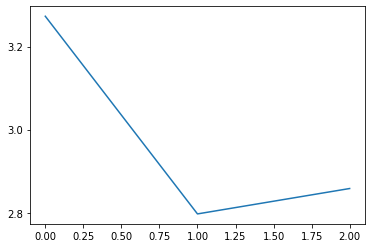

In [195]:
trainer.trainIters(input_src,input_target,300)

In [19]:
del trainer
gc.collect()

188

# test

In [20]:
val_data_id = val_data[src_col].apply(lambda x:Langs["src"].word2id(x))

In [21]:
val_data_id[:10]

15043                        [206, 20, 560, 8, 1643, 5, 0]
15044                    [25, 52, 8, 205, 358, 4270, 5, 0]
15045        [10, 512, 351, 215, 3569, 32, 27, 2130, 5, 0]
15046                       [18, 56, 1740, 397, 765, 5, 0]
15047    [111, 44, 753, 65, 1793, 50, 455, 79, 2360, 5, 0]
15048                    [175, 1875, 27, 2983, 2363, 5, 0]
15049                    [170, 75, 44, 2, 614, 1219, 5, 0]
15050             [490, 22, 44, 2, 2, 12, 144, 1109, 5, 0]
15051                           [4, 56, 2, 111, 121, 5, 0]
15052        [63, 792, 7, 584, 256, 16, 44, 591, 37, 5, 0]
Name: description_en, dtype: object

In [148]:
translator = Translator(config)

NameError: name 'build_model' is not defined

In [23]:
ret = translator.translate_demo(val_data_id)

In [24]:
for src,pred,target in zip(val_data[src_col],ret,val_data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

src-> theres no need to hurry.

pred-> 急が ない と 遅れる よ 。 EOS
ans-> 急ぐ 必要 は あり ませ ん 。
------------------
src-> i want to join your band.

pred-> UNK の 方 が UNK さ れ てる よ 。 EOS
ans-> あなた の バンド に 入り たい な 。
------------------
src-> you must keep an eye on the child.

pred-> その 本 は UNK に なり たい 。 EOS
ans-> その 子 から 目 を 離さ ない よう に し なけれ ば いけ ない 。
------------------
src-> he is mad about music.

pred-> 彼 は 音楽 が 好き で ある 。 EOS
ans-> 彼 は 音楽 狂 だ 。
------------------
src-> with a little more patience she would have succeeded.

pred-> 彼女 が そんな こと を し た ので 、 私 は 何 か 知っ て い まし た 。 EOS
ans-> もし 彼女 が もう少し 我慢強かっ たら 、 成功 し て い た だろ う に 。
------------------
src-> they painted the fence green.

pred-> 彼ら は UNK で UNK し て いる 。 EOS
ans-> 彼ら は フェンス を 緑色 に 塗っ た 。
------------------
src-> there was a convention last month.

pred-> UNK が UNK た 。 EOS
ans-> 先月 、 集会 が あっ た 。
------------------
src-> shes not a fulltime employee of this company.

pred-> 彼女 は UNK UNK も 全く 速く UNK 。 EOS
ans-> 彼女 は この 会社 の 正社員 で は あり ませ ん 。
--